[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PTB-MR/mrpro/blob/main/examples/notebooks/regularized_iterative_sense_reconstruction.ipynb) [![Download notebook](https://img.shields.io/badge/Download-notebook-blue?logo=jupyter)](path:regularized_iterative_sense_reconstruction.ipynb)

In [1]:
import importlib

if not importlib.util.find_spec('mrpro'):
    %pip install mrpro[notebook]

# Regularized Iterative SENSE Reconstruction of 2D golden angle radial data
Here we use the RegularizedIterativeSENSEReconstruction class to reconstruct images from ISMRMRD 2D radial data

In [2]:
# define zenodo URL of the example ismrmd data
zenodo_url = 'https://zenodo.org/records/10854057/files/'
fname = 'pulseq_radial_2D_402spokes_golden_angle_with_traj.h5'

In [3]:
# Download raw data
import tempfile

import requests

data_file = tempfile.NamedTemporaryFile(mode='wb', delete=False, suffix='.h5')
response = requests.get(zenodo_url + fname, timeout=30)
data_file.write(response.content)
data_file.flush()

### Image reconstruction
We use the RegularizedIterativeSENSEReconstruction class to reconstruct images from 2D radial data.
RegularizedIterativeSENSEReconstruction solves the following reconstruction problem:

Let's assume we have obtained the k-space data $y$ from an image $x$ with an acquisition model (Fourier transforms,
coil sensitivity maps...) $A$ then we can formulate the forward problem as:

$ y = Ax + n $

where $n$ describes complex Gaussian noise. The image $x$ can be obtained by minimizing the functionl $F$

$ F(x) = ||W^{\frac{1}{2}}(Ax - y)||_2^2 $

where $W^\frac{1}{2}$ is the square root of the density compensation function (which corresponds to a diagonal
operator). Because this is an ill-posed problem, we can add a regularization term to stabilize the problem and obtain
a solution with certain properties:

$ F(x) = ||W^{\frac{1}{2}}(Ax - y)||_2^2 + l||Bx - x_{reg}||_2^2$

where $l$ is the strength of the regularization, $B$ is a linear operator and $x_{reg}$ is a regularization image.
With this functional $F$ we obtain a solution which is close to $x_{reg}$ and to the acquired data $y$.

Setting the derivative of the functional $F$ to zero and rearranging yields

$ (A^H W A + l B) x = A^H W y + l x_{reg}$

which is a linear system $Hx = b$ that needs to be solved for $x$.

One important question of course is, what to use for $x_{reg}$. For dynamic images (e.g. cine MRI) low-resolution
dynamic images or high-quality static images have been proposed. In recent years, also the output of neural-networks
has been used as an image regulariser.

In this example we are going to use a high-quality image to regularize the reconstruction of an undersampled image.
Both images are obtained from the same data acquisition (one using all the acquired data ($x_{reg}$) and one using
only parts of it ($x$)). This of course is an unrealistic case but it will allow us to study the effect of the
regularization.

In [4]:
import mrpro

##### Read-in the raw data

In [5]:
from mrpro.data import KData
from mrpro.data.traj_calculators import KTrajectoryIsmrmrd

# Load in the Data and the trajectory from the ISMRMRD file
kdata = KData.from_file(data_file.name, KTrajectoryIsmrmrd())
kdata.header.recon_matrix.x = 256
kdata.header.recon_matrix.y = 256

##### Image $x_{reg}$ from fully sampled data

In [6]:
from mrpro.algorithms.reconstruction import DirectReconstruction, IterativeSENSEReconstruction
from mrpro.data import CsmData

# Estimate coil maps
direct_reconstruction = DirectReconstruction(kdata, csm=None)
img_coilwise = direct_reconstruction(kdata)
csm = CsmData.from_idata_walsh(img_coilwise)

# Iterative SENSE reconstruction
iterative_sense_reconstruction = IterativeSENSEReconstruction(kdata, csm=csm, n_iterations=3)
img_iterative_sense = iterative_sense_reconstruction(kdata)

##### Image $x$ from undersampled data

In [7]:
import torch

# Data undersampling, i.e. take only the first 20 radial lines
idx_us = torch.arange(0, 20)[None, :]
kdata_us = kdata.split_k1_into_other(idx_us, other_label='repetition')

In [8]:
# Iterativ SENSE reconstruction
iterative_sense_reconstruction = IterativeSENSEReconstruction(kdata_us, csm=csm, n_iterations=6)
img_us_iterative_sense = iterative_sense_reconstruction(kdata_us)

In [9]:
# Regularized iterativ SENSE reconstruction
from mrpro.algorithms.reconstruction import RegularizedIterativeSENSEReconstruction

regularization_weight = 1.0
n_iterations = 6
regularized_iterative_sense_reconstruction = RegularizedIterativeSENSEReconstruction(
    kdata_us,
    csm=csm,
    n_iterations=n_iterations,
    regularization_data=img_iterative_sense.data,
    regularization_weight=regularization_weight,
)
img_us_regularized_iterative_sense = regularized_iterative_sense_reconstruction(kdata_us)

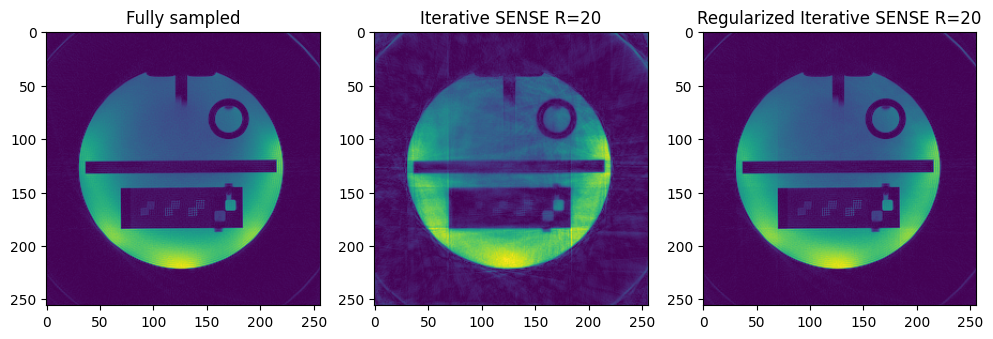

In [10]:
import matplotlib.pyplot as plt

vis_im = [img_iterative_sense.rss(), img_us_iterative_sense.rss(), img_us_regularized_iterative_sense.rss()]
vis_title = ['Fully sampled', 'Iterative SENSE R=20', 'Regularized Iterative SENSE R=20']
fig, ax = plt.subplots(1, 3, squeeze=False, figsize=(12, 4))
for ind in range(3):
    ax[0, ind].imshow(vis_im[ind][0, 0, ...])
    ax[0, ind].set_title(vis_title[ind])

### Behind the scenes

##### Set-up the density compensation operator $W$ and acquisition model $A$

This is very similar to the iterative SENSE reconstruction. For more detail please look at the
iterative_sense_reconstruction notebook.

In [11]:
dcf_operator = mrpro.data.DcfData.from_traj_voronoi(kdata_us.traj).as_operator()
fourier_operator = mrpro.operators.FourierOp.from_kdata(kdata_us)
csm_operator = csm.as_operator()
acquisition_operator = fourier_operator @ csm_operator

##### Calculate the right-hand-side of the linear system $b = A^H W y + l x_{reg}$

In [12]:
right_hand_side = (
    acquisition_operator.H(dcf_operator(kdata_us.data)[0])[0] + regularization_weight * img_iterative_sense.data
)

##### Set-up the linear self-adjoint operator $H = A^H W A + l$

In [13]:
from mrpro.operators import IdentityOp

operator = acquisition_operator.H @ dcf_operator @ acquisition_operator + IdentityOp() * torch.as_tensor(
    regularization_weight
)

##### Run conjugate gradient

In [14]:
img_manual = mrpro.algorithms.optimizers.cg(
    operator, right_hand_side, initial_value=right_hand_side, max_iterations=n_iterations, tolerance=0.0
)

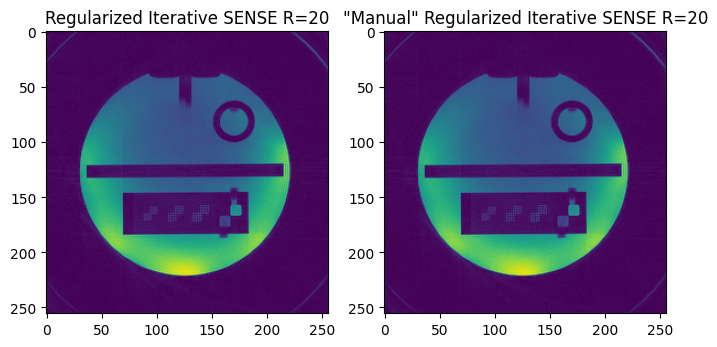

In [15]:
# Display the reconstructed image
vis_im = [img_us_regularized_iterative_sense.rss(), img_manual.abs()[:, 0, ...]]
vis_title = ['Regularized Iterative SENSE R=20', '"Manual" Regularized Iterative SENSE R=20']
fig, ax = plt.subplots(1, 2, squeeze=False, figsize=(8, 4))
for ind in range(2):
    ax[0, ind].imshow(vis_im[ind][0, 0, ...])
    ax[0, ind].set_title(vis_title[ind])

### Check for equal results
The two versions should result in the same image data.

In [16]:
# If the assert statement did not raise an exception, the results are equal.
assert torch.allclose(img_us_regularized_iterative_sense.data, img_manual)

### Next steps
Play around with the regularization_weight to see how it effects the final image quality.

Of course we are cheating here because we used the fully sampled image as a regularization. In real world applications
we would not have that. One option is to apply a low-pass filter to the undersampled k-space data to try to reduce the
streaking artifacts and use that as a regularization image. Try that and see if you can also improve the image quality
compared to the unregularised images.